In [33]:
%matplotlib inline
import cmlreaders as cml
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [34]:
all_catfr1_events = cml.CMLReader.load_events(experiments=["catFR1"], data_type='task_events')

In [35]:
events = all_catfr1_events.query('type == ["WORD", "REC_WORD"]')
# events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0] # removing practice lists

In [36]:
#removing subjects who were presented with the same word multiple times (probably repeated data)
word_evs = events.query('type == "WORD"')
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()

#drop subjects without 12 items per list
n_list_pres = word_evs.groupby(['subject', 'session', 'list']).size().to_frame(name='n').reset_index()
bad_lists = n_list_pres.query('n != 12')
bad_subs += bad_lists.subject.unique().tolist()

#drop subjects with no recalls
n_types = events.groupby('subject').agg({'type': 'nunique'}).reset_index()
no_recall_subs = n_types.query('type != 2')
bad_subs += no_recall_subs.subject.unique().tolist()

#drop subjects with messed up recalls
rec_evs = events.query('type == "REC_WORD"')
joint_evs = word_evs.merge(rec_evs[['subject', 'session', 'list', 'category', 'item_name']], how='left', indicator=True)
bad_subs += joint_evs.query('(recalled == 1 and _merge != "both") or (recalled == 0 and _merge == "both")').subject.unique()

events.query('subject not in @bad_subs', inplace=True)

In [37]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

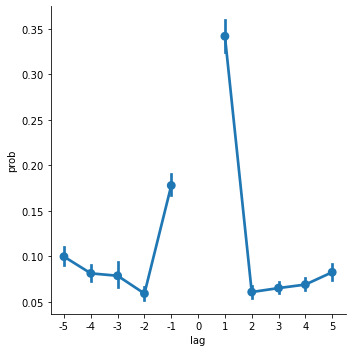

In [38]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )

In [39]:
pb_temp_fact = events.groupby("subject").apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,temp_fact
0,R1004D,0.677778
1,R1013E,0.614322
2,R1015J,0.584127
3,R1016M,0.598297
4,R1021D,0.630544
...,...,...
239,R1542J,0.651343
240,R1616S,0.551848
241,R1617S,0.604552
242,R1626S,0.583251


In [41]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df['item_num'] = item_num_df['item_num'] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [42]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [43]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [45]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [46]:
sem_sim_df

,item_1,item_2
0,DESK,DESK
1,DESK,TABLE
2,DESK,CARROT
3,DESK,CUCUMBER
4,DESK,HAWK
...,...,...
364811,DIENTE,TERCIOPELO
364812,DIENTE,MEZCLILLA
364813,DIENTE,SEDA
364814,DIENTE,CHURRO


In [47]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [48]:
sem_sim_df.to_csv('/scratch/djh/catfr1_sem_sim_df.csv')

In [49]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on=item_col).merge(
    item_num_df, left_on='item_2', right_on=item_col, suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

In [50]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [51]:
events_new.query('item_num_new == -999')

,category,category_num,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,item_name,item_num,...,recognized,rectime,rejected,serialpos,session,stim_list,stim_params,subject,type,item_num_new
232,X,-999,R1004D_11Nov14_1100,5688532,1.02,catFR1,-1,False,DUCKS,-1,...,NaN,13978,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
272,X,-999,R1004D_11Nov14_1100,6323298,1.02,catFR1,-1,False,COBRA,-1,...,NaN,23021,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
323,X,-999,R1004D_11Nov14_1100,7043183,1.02,catFR1,-1,False,GOOD,-1,...,NaN,13739,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
847,X,-999,R1015J_catFR1_0_18Jan15_1549,2089087,1.03,catFR1,-1,False,STAND,-1,...,NaN,6157,NaN,-999,0,False,[],R1015J,REC_WORD,-999.0
878,X,-999,R1016M_catFR1_0_20Jan15_1032,589344,1.03,catFR1,-1,False,WATERMELON,-1,...,NaN,23553,NaN,-999,0,False,[],R1016M,REC_WORD,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145023,X,-999,R1627T_catFR1_0_03Aug22_1535,685061,,catFR1,-1,False,STORM,-1,...,-999.0,8836,-999.0,-999,0,True,NaN,R1627T,REC_WORD,-999.0
145082,X,-999,R1627T_catFR1_0_03Aug22_1535,981294,,catFR1,-1,False,TOY,-1,...,-999.0,14399,-999.0,-999,0,True,NaN,R1627T,REC_WORD,-999.0
145099,X,-999,R1627T_catFR1_0_03Aug22_1535,1073612,,catFR1,-1,False,PALM,-1,...,-999.0,9256,-999.0,-999,0,True,NaN,R1627T,REC_WORD,-999.0
145207,X,-999,R1627T_catFR1_1_05Aug22_1537,484242,,catFR1,-1,False,DRINK,-1,...,-999.0,19316,-999.0,-999,1,True,NaN,R1627T,REC_WORD,-999.0


In [52]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

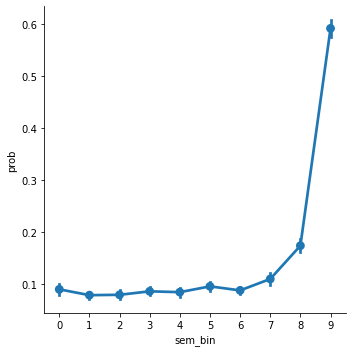

In [53]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp
           )

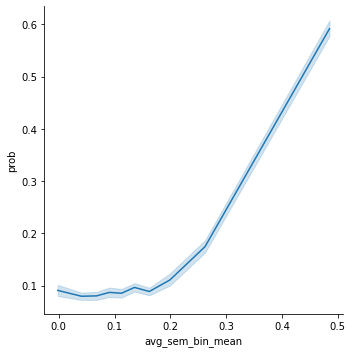

In [54]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.relplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp, kind='line')

In [55]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False
                                                       ).to_frame(name='sem_fact').reset_index()

pb_sem_dist_fact

,subject,sem_fact
0,R1004D,0.666667
1,R1013E,0.709021
2,R1015J,0.479365
3,R1016M,0.662442
4,R1021D,0.738065
...,...,...
239,R1542J,0.753351
240,R1616S,0.733506
241,R1617S,0.613218
242,R1626S,0.655570
